In [1]:
'''
get kaggle dataset
'''
!pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c digit-recognizer

 91%|██████████████████████████████████▋   | 14.0M/15.3M [00:00<00:00, 68.2MB/s]
100%|██████████████████████████████████████| 15.3M/15.3M [00:00<00:00, 66.6MB/s]


In [2]:
!unzip ./digit-recognizer.zip

Archive:  ./digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
from IPython.display import clear_output

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install opencv-python
clear_output()

In [6]:
def data_preprocessing(data):

    NEW_COLUMNS = ["label_" + str(i) for i in range(10)] + [
        "pixel" + str(i) for i in range(784)
    ]

    if "label" in data.columns:
        data = data.join(pd.get_dummies(data.label, prefix="label"))
    data = pd.DataFrame(data, columns=NEW_COLUMNS)
    data = data.fillna(0)

    return data


In [8]:
"""
確認資料格式
"""
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


data = pd.read_csv("train.csv")
print(data[:3])
print(math.sqrt(784))


   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  

[3 rows x 785 columns]
28.0


In [9]:
"""
分離出 train, valid 的輸入輸出
"""

train = data.sample(frac=0.7, random_state=12345)
valid = data.drop(train.index)


train_x = train.drop(labels=["label"], axis=1)
train_y = train["label"]

valid_x = valid.drop(labels=["label"], axis=1)
valid_y = valid["label"]
print(train_x.shape)
print(train_y.shape)


(29400, 784)
(29400,)


<Figure size 432x288 with 0 Axes>

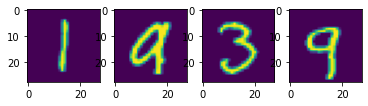

39708    1
40011    9
40531    3
33023    9
Name: label, dtype: int64


In [10]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

train_x_nd = np.array(train_x.values.tolist(), dtype=int)


train_x_nd = train_x_nd.reshape(train_x_nd.shape[0], 28, 28)
train_x_nd = np.expand_dims(train_x_nd, axis=1)
images = train_x_nd.astype(np.uint8)
plt.figure()
f, axarr = plt.subplots(1, 4)
for i in range(4):
    axarr[i].imshow(images[i][0])
plt.show()
print(train_y.head(4))


In [14]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)


1.8.1
True
device:  cuda:0


In [30]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1
            ),  # (16,28,28)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1
            ),  # (16,28,28)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (16,14,14)
            nn.Conv2d(
                in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1
            ),  # (8,14,14)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1
            ),  # (8,14,14)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (8,7,7)
            nn.Flatten(1, -1),  # start_dim, end_dim
            nn.Linear(392, 16),  # 392 = 8*7*7
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(16, 10),
        )

    def forward(self, input):
        out = self.net(input)
        return out


In [31]:
model = CNN().to(device)
print(model)
train_x_tensor = torch.tensor(train_x_nd, dtype=torch.float).to(device)

print(model(train_x_tensor[:2, :, :, :]).shape)


CNN(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=392, out_feature

In [32]:
"""
hyperparameters
"""
epochs = 50
learning_rate = 0.0001
batch_size = 8
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [33]:
train_inputs = torch.tensor(train_x.values.tolist(), dtype=torch.float32).to(device)

train_inputs = torch.reshape(train_inputs, (train_inputs.shape[0], 28, 28))
train_inputs = torch.unsqueeze(train_inputs, dim=1)

train_labels = torch.tensor(train_y.values.tolist(), dtype=torch.float32).to(device)


valid_inputs = torch.tensor(valid_x.values.tolist(), dtype=torch.float32).to(device)

valid_inputs = torch.reshape(valid_inputs, (valid_inputs.shape[0], 28, 28))
valid_inputs = torch.unsqueeze(valid_inputs, dim=1)


valid_labels = torch.tensor(valid_y.values.tolist(), dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_inputs, train_labels)
trainLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)


best_loss = 1000000000
best_accuracy = 0

for epoch_index, epoch in enumerate(range(epochs), 0):
    model.train()
    for i, batch in enumerate(trainLoader, 0):
        inputs, labels = batch

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()

        optimizer.step()

    if epoch_index % 1 == 0:
        model.eval()
        with torch.no_grad():
            outputs = model(valid_inputs)
            loss = criterion(outputs, valid_labels.long())
            if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), "model.pk1")
                _, predicted = torch.max(outputs, 1)
                best_accuracy = (
                    ((predicted == valid_labels).sum().item())
                    / valid_labels.shape[0]
                    * 100
                )

            if epoch_index % 10 == 0:
                print("epoches: ", epoch_index, "loss: ", loss.item())
                print("valid - epoches: ", epoch_index, "loss: ", loss.item())
                _, predicted = torch.max(outputs, 1)
                print(
                    "Accuracy in valid set: ",
                    str(
                        ((predicted == valid_labels).sum().item())
                        / valid_labels.shape[0]
                        * 100
                    )
                    + "%",
                )

print("best loss in valid: ", best_loss.item())
print("It's accuracy: ", best_accuracy)


epoches:  0 loss:  0.666256844997406
valid - epoches:  0 loss:  0.666256844997406
Accuracy in valid set:  94.57142857142857%
epoches:  10 loss:  0.052071359008550644
valid - epoches:  10 loss:  0.052071359008550644
Accuracy in valid set:  98.33333333333333%
epoches:  20 loss:  0.043777946382761
valid - epoches:  20 loss:  0.043777946382761
Accuracy in valid set:  98.65079365079366%
epoches:  30 loss:  0.038312144577503204
valid - epoches:  30 loss:  0.038312144577503204
Accuracy in valid set:  98.90476190476191%
epoches:  40 loss:  0.03601710498332977
valid - epoches:  40 loss:  0.03601710498332977
Accuracy in valid set:  98.85714285714286%
best loss in valid:  0.03339292109012604
It's accuracy:  98.93650793650794


In [34]:
model.load_state_dict(torch.load("model.pk1"))
model.eval()


data = pd.read_csv("test.csv")

test_inputs = torch.tensor(data.values.tolist(), dtype=torch.float32).to(device)
test_inputs = torch.reshape(test_inputs, (test_inputs.shape[0], 28, 28))
test_inputs = torch.unsqueeze(test_inputs, dim=1)

test_ans = []

for row in test_inputs:
    test_ans.append(torch.max(model(torch.unsqueeze(row, dim=0)), 1)[1].item())


submission = pd.read_csv("./sample_submission.csv")
submission["Label"] = torch.tensor(test_ans).cpu()
submission.to_csv("./sample_submission.csv", index=False)
